## A custom linear PCA class

#### In this notebook I create my own linear PCA class using numpy. The main innovation of this class over Sklearn is that it produces a series of useful scree plots.  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import unittest


class LinearPCA:    
    '''A class used to implement linear principal components analysis
    ...
    
    Properties
    ----------
    eigenvalues : np.ndarray
        The eigenvalues recovered from the covariance matrix of the input matrix X
    
    eigenvectors :  np.ndarray
        The eigenvectors recovereed from the covariance matrix of the input matrix X
    
    components : int
        The number of principal components specified by the user, this is optional
    
    rescaled : np.ndarray
        The eigenvectors projected onto the original input matrix X
    
    total_variance_explained :  np.ndarray
        A sorted array containing the proportion of variance explained by each principal component
    
    cumulative_variance :  np.ndarray
        A sorted array containing the cumulative proportion of variance explained by each principal component
    
    
    Methods
    -------
    
    fit(X, transform=None)
        X : np.ndarray
        transform : str
        
        'Fits' the PCA given a specified number of components X and allows the user to specify mean centring or zero-mean, 
        unit-variance standardisation
    
    scree_plot(y='total_variance', variance_threshold = None)
        y : str
        variance_threshold : float
        
        returns a scree plot in order to visualise the principle components based on total variance, cumulative variance and
        the raw eigenvalues
    
    '''
    def __init__(self, components=None):
        '''
        Parameters
        ----------
        components : int
            Optional user defined components, must be an integer
        
        Raises
        ------
        ValueError
            If the component parameter is either not an int or is not None
        
        '''
        
        if isinstance(components, int) or components is None:
            self._components = components
        else:
            raise ValueError("Components must be an integer")

    @property
    def eigenvectors(self):
        '''Read-only, returns the eigenvectos'''
        return self._eigenvectors
    
    @property
    def eigenvalues(self):
        '''Read-only, returns the eigenvalues'''
        return self._eigenvalues
    
    @property
    def rescaled(self):
        '''Read-only, returns the rescaled data'''
        return self._rescaled
    
    @property
    def total_variance_explained(self):
        '''Read-only, returns the total variance explained by each component'''
        return self._total_variance_explained
    
    @property
    def components(self):
        '''Read-only, returns the number of components specified by the user'''
        return self._components

    @property
    def cumulative_variance(self):
        '''Read-only, returns the cumulative varianced explained by each component '''
        return self._cumulative_variance
    
    def fit(self, x, transform=None,**kwargs):
        '''Extracts the principal components from an input matrix X 
        
        Parameters
        ----------
        X : np.ndarray
        transform : str
            Gives the user the option to mean centre X (transform = mean) or to standardise X with zero mean and unit standard deviation
            (transform = standardise). The default parameter is to apply no transformation at all
        
        Raises
        ------
        TypeError
            If the input matrix X is not an np.ndarray
        
        '''
        
        if isinstance(x, np.ndarray):
            pass
        else:
            #TO DO: This might be too restrictive, consider broadening
            raise TypeError("Input matrix X must be a numpy array")
        
        if transform == 'mean':
            x -= x.mean(axis=0)
        elif transform == 'standardise':
            x -= x.mean(axis=0)
            x /= x.std(axis=0)
        else:
            x = x 
        variance_covariance_matrix = np.cov(x, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(variance_covariance_matrix)
            
        if self._components:
            order_idx = np.argsort(eigenvalues)[::-1][0:self._components]
        else:
            order_idx = np.argsort(eigenvalues)[::-1]
        self._eigenvectors = eigenvectors[:,order_idx]
        self._eigenvalues = eigenvalues[order_idx]
        self._rescaled = np.dot(x, self.eigenvectors)
        self._total_variance_explained = self._eigenvalues/sum(self._eigenvalues)
        self._cumulative_variance = np.cumsum(self._total_variance_explained)
    
    def chart_params(self):
        ''' Stores chart paramaters in a dictionary in order to reduce code redundency in the plots'''
        
        chart_params = {'total_variance': {'title': 'Total Variance Explained', 
                                           'y_lab':'Variance Explained',
                                           'x_lab': 'Number of components', 
                                           'value': self._total_variance_explained,
                                           'x_min':1,
                                           'x_max': len(self._total_variance_explained)+1},
                         'eigenvalues': {'title': 'Eigenvalues', 
                                         'y_lab': 'Eigenvalues',
                                         'x_lab': 'Number of components',
                                         'value': self._eigenvalues,
                                         'x_min': 1,
                                         'x_max': len(self._eigenvalues)+1},
                         'cumulative': {'title': 'Cumulative Variance Explained', 
                                         'y_lab': 'Cumulative variance',
                                         'x_lab': 'Number of components',
                                         'value': np.hstack((0,self._cumulative_variance)),
                                         'x_min': 0,
                                         'x_max': len(self._cumulative_variance)+1},
                         }
        return chart_params
    
    def scree_plot(self, y = 'total_variance', variance_threshold=None):
        ''' returns a scree plot in order to visualise the principle components
        
        Parameters
        ----------
        y : str
            (1) y = 'total_variance' to plot the total variance explained by each component
            (2) y = 'eigenvalues' to plot the values of the eigenvalues for each component
            (3) y = 'cumulative' to plot the cumulative variance explained by each component
            
        variance_threshold : float
            This only works for the cumulative plot and allows the user to visualise see the number 
            components closest to a specified variance tolerance.
        
        Raises
        ------
        KeyError
            If the user does not specify total_variance, eigenvalues or cumulative for y
        
        ValueError
            If a variance_threshold not None for a total_variance or eigenvalues plot
            
            '''
        y = y.strip().lower()
        
        if variance_threshold:
            if variance_threshold < 0.0 or variance_threshold > 1.0:
                raise ValueError("The threshold must be between 0 and 1")
            
        if y not in self.chart_params():
            raise KeyError("Must specify either total_variance, eigenvalues or cumulative")
        elif (y == 'eigenvalues' or y=='total_variance') and variance_threshold is not None:
            raise ValueError("Cannot specify a variance threshold when plotting the eigenvalues")
        else:
            title, y_lab, x_lab, values, x_min, x_max = self.chart_params()[y].values()
            fig = plt.figure()
            
            plt.plot(range(x_min, x_max), values, color='darkmagenta')
            fig.suptitle(title, fontsize=12)
            plt.xlabel(x_lab)
            plt.xticks(np.arange(x_min, x_max, 1))
            plt.ylim(ymin=0)
            plt.ylabel(y_lab)
            if y == 'cumulative' and variance_threshold:
                min_component = np.abs(np.subtract.outer(values,variance_threshold)).argmin(0)
                plt.axhline(values[min_component],linestyle='dashed', color='black', linewidth=1)
                plt.axvline(min_component, linestyle='dashed', color='black', linewidth=1)


### A short example

In [2]:
from sklearn import datasets

boston = datasets.load_boston()
features = boston.data

p = LinearPCA()
p.fit(features, transform='mean')

In [3]:
p.total_variance_explained

array([8.05823175e-01, 1.63051968e-01, 2.13486092e-02, 6.95699061e-03,
       1.29995193e-03, 7.27220158e-04, 4.19044539e-04, 2.48538539e-04,
       8.53912023e-05, 3.08071548e-05, 6.65623182e-06, 1.56778461e-06,
       7.96814208e-08])

In [4]:
p.eigenvalues

array([3.08899113e+04, 6.25033006e+03, 8.18363958e+02, 2.66684838e+02,
       4.98315275e+01, 2.78767934e+01, 1.60633859e+01, 9.52731770e+00,
       3.27333185e+00, 1.18094181e+00, 2.55155742e-01, 6.00984544e-02,
       3.05445673e-03])

In [5]:
p.cumulative_variance

array([0.80582318, 0.96887514, 0.99022375, 0.99718074, 0.99848069,
       0.99920791, 0.99962696, 0.9998755 , 0.99996089, 0.9999917 ,
       0.99999835, 0.99999992, 1.        ])

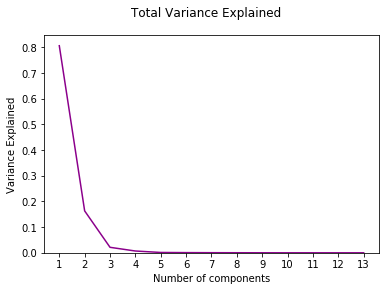

In [6]:
p.scree_plot(y = 'total_variance')


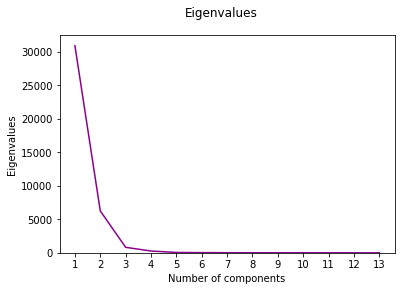

In [7]:
p.scree_plot(y = 'Eigenvalues')

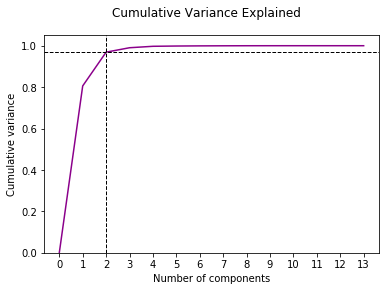

In [8]:
p.scree_plot(y = 'cumulative', variance_threshold=0.91)

### Comparison with Sklearn

In [9]:
from sklearn.decomposition import PCA
import pandas as pd

features_centred = features - features.mean(axis=0)
pca = PCA()
pca_features = pca.fit_transform(features_centred)


In [10]:
pd.DataFrame({'sklearn': np.round(pca.explained_variance_ratio_,6), 'My Class':np.round(p.total_variance_explained,6)})

,sklearn,My Class
0,0.805823,0.805823
1,0.163052,0.163052
2,0.021349,0.021349
3,0.006957,0.006957
4,0.001300,0.001300
5,0.000727,0.000727
6,0.000419,0.000419
7,0.000249,0.000249
8,0.000085,0.000085
9,0.000031,0.000031


### Some Unit testing

In [11]:

def run_tests(test_class):
    suite = unittest.TestLoader().loadTestsFromTestCase(test_class)
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)
    
class TestLinearPCA(unittest.TestCase):
    def setUp(self):
        print("Running setup")
        self.features = datasets.load_boston().data
        self.total_variance_explained = np.array([8.05823175e-01, 1.63051968e-01, 2.13486092e-02, 6.95699061e-03,
                                                   1.29995193e-03, 7.27220158e-04, 4.19044539e-04, 2.48538539e-04,
                                                   8.53912023e-05, 3.08071548e-05, 6.65623182e-06, 1.56778461e-06,
                                                   7.96814208e-08])
        self.eigenvalues = np.array([3.08899113e+04, 6.25033006e+03, 8.18363958e+02, 2.66684838e+02,
                                                   4.98315275e+01, 2.78767934e+01, 1.60633859e+01, 9.52731770e+00,
                                                   3.27333185e+00, 1.18094181e+00, 2.55155742e-01, 6.00984544e-02,
                                                   3.05445673e-03])                               
        self.cumulative_variance = np.array([0.80582318, 0.96887514, 0.99022375, 0.99718074, 0.99848069,
                                             0.99920791, 0.99962696, 0.9998755 , 0.99996089, 0.9999917 ,
                                             0.99999835, 0.99999992, 1.        ])
    
    
    def tearDown(self):
        print("Running teardown")
        pass

    # delegate almost equal checking to this function in order to minimise redundancy
    def almost_equal(self, arr1, arr2):
        try:
            np.testing.assert_almost_equal(arr1, arr2, decimal=3)
            result = True
        except AssertionError as error:
            result = False
            print(error)
        self.assertTrue(result)

    def test_total_variance_explained(self):
        p = LinearPCA()
        p.fit(self.features, transform='mean')
        
        self.almost_equal(self.total_variance_explained, p.total_variance_explained)
        
        
    def test_eigenvalues(self):
        p = LinearPCA()
        p.fit(self.features, transform='mean')
    
        
        self.almost_equal(self.eigenvalues, p.eigenvalues)
    
    def test_cumulative_variance(self):
        p = LinearPCA()
        p.fit(self.features, transform='mean')
        self.almost_equal(self.cumulative_variance, p.cumulative_variance)
        
    def test_components_init(self):
        components = 5
        p = LinearPCA(components)
        self.assertEqual(components, p.components)
    
    def test_components_type(self):
        components = 0.7
        
        
        with self.assertRaises(ValueError):
            p = LinearPCA(components)

    def test_input_type(self):
        string = '397302034'
        lst = [2,3,4,51,9,12,0]
        
        with self.assertRaises(TypeError):
            p = LinearPCA()
            p.fit(string)
        
        with self.assertRaises(TypeError):
            p = LinearPCA()
            p.fit(lst)
            
    # delegate plot creation checking to this function in order to minimise redundancy
    def plot_creation_checker(self, plot_type):
        
        p = LinearPCA()
        p.fit(self.features, transform='mean')
        try:
            p.scree_plot(y=plot_type)
            result = True
        except KeyError as error:
            result = False
            print(error)
            self.assertTrue(result)
            
    def test_total_variance_plot_creation(self):
        self.plot_creation_checker('total_variance')

    def test_eigenvalues_plot_creation(self):
        self.plot_creation_checker('eigenvalues')
    
    def test_cumulative_plot_creation(self):
        self.plot_creation_checker('cumulative')
    
    def test_scree_input_clean(self):
        
        p = LinearPCA()
        p.fit(self.features, transform='mean')
            
        try:
            p.scree_plot(y='CumulaTive ')
            result = True
        except KeyError as error:
            result = False
            print(error)
            self.assertTrue(result)
    
    def test_scree_input_type(self):
        
        with self.assertRaises(KeyError):
            p = LinearPCA()
            p.fit(self.features)
            p.scree_plot(y='random')
    
    def test_scree_variance_threshold(self):
        p = LinearPCA()
        p.fit(self.features, transform='mean')
        
        try:
            p.scree_plot(y='cumulative', variance_threshold = -0.1)
            result = False
        except ValueError as error:
            result = True
            self.assertTrue(result)

test_components_init (__main__.TestLinearPCA) ... ok
test_components_type (__main__.TestLinearPCA) ... ok
test_cumulative_plot_creation (__main__.TestLinearPCA) ... ok
test_cumulative_variance (__main__.TestLinearPCA) ... ok
test_eigenvalues (__main__.TestLinearPCA) ... ok
test_eigenvalues_plot_creation (__main__.TestLinearPCA) ... 

Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup


ok
test_input_type (__main__.TestLinearPCA) ... ok
test_scree_input_clean (__main__.TestLinearPCA) ... ok
test_scree_input_type (__main__.TestLinearPCA) ... ok
test_scree_variance_threshold (__main__.TestLinearPCA) ... ok
test_total_variance_explained (__main__.TestLinearPCA) ... ok
test_total_variance_plot_creation (__main__.TestLinearPCA) ... 

Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup
Running teardown
Running setup


ok

----------------------------------------------------------------------
Ran 12 tests in 0.461s

OK


Running teardown


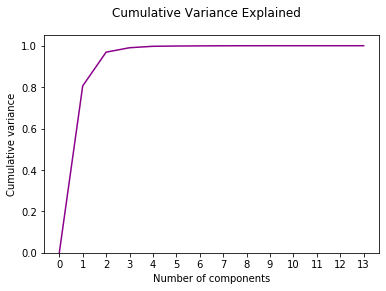

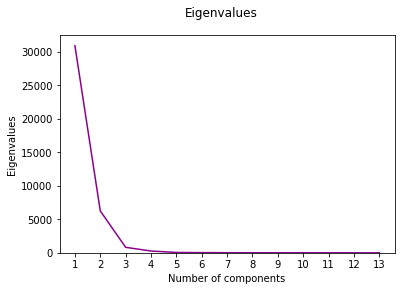

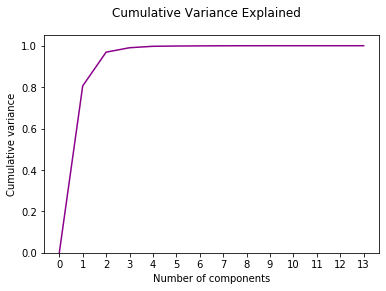

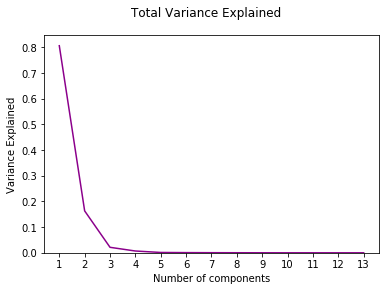

In [12]:
run_tests(TestLinearPCA)